In [12]:
!conda install -c conda-forge/label/cf201901 fbprophet

^C


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

ModuleNotFoundError: No module named 'fbprophet'

In [2]:
df = pd.read_excel('df_ENA_Sudeste.xlsx')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Month,Day,Year,ENA_obs,ENA_chuva,ENA_chuva_2,ENA_chuva_3,Season,EA
Date,,,,,,,,,
2007-01-01,1,1,2007,60591,1.304345,13.043453,130.434532,1,102089.0
2007-01-02,1,2,2007,63626,0.295972,2.959719,29.597191,1,103516.0
2007-01-03,1,3,2007,67542,6.389694,63.896942,638.969424,1,105066.0
2007-01-04,1,4,2007,71993,9.954444,99.544439,995.444391,1,106831.0
2007-01-05,1,5,2007,77341,13.716017,137.160172,1371.601717,1,108892.0


In [4]:
daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()

d_df['date_index'] = d_df['Date']
d_df['date_index'] = pd.to_datetime(d_df['date_index'])
d_df = d_df.set_index('date_index')
d_df=d_df[['Date','ENA_obs','ENA_chuva','Season', 'EA']]

In [5]:
d_df.head()

,Date,ENA_obs,ENA_chuva,Season,EA
date_index,,,,,
2007-01-01,2007-01-01,60591,1.304345,1,102089.0
2007-01-02,2007-01-02,63626,0.295972,1,103516.0
2007-01-03,2007-01-03,67542,6.389694,1,105066.0
2007-01-04,2007-01-04,71993,9.954444,1,106831.0
2007-01-05,2007-01-05,77341,13.716017,1,108892.0


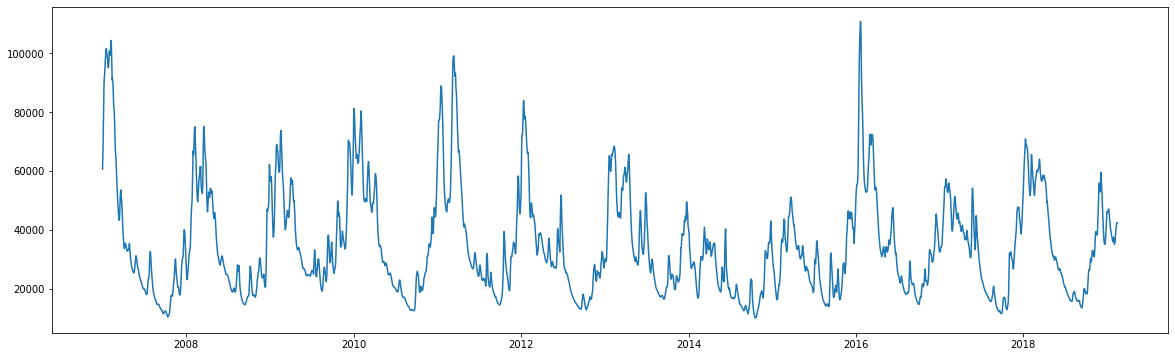

In [6]:
d_df.columns = ['ds', 'y', 'ENA_chuva','Season', 'EA']

fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(d_df.ds, d_df.y)

In [7]:
d_df['cap']=100000
d_df.tail()

,ds,y,ENA_chuva,Season,EA,cap
date_index,,,,,,
2019-02-10,2019-02-10,40782,0.146148,1,53637.093750,100000
2019-02-11,2019-02-11,41336,4.477100,1,53375.347656,100000
2019-02-12,2019-02-12,42111,10.478274,1,53306.972656,100000
2019-02-13,2019-02-13,42424,0.814051,1,53323.078125,100000
2019-02-14,2019-02-14,42405,0.114348,1,53433.339844,100000


In [40]:
prev = pd.read_excel('GFS-por_região-16_dias_17042020.xlsx')
prev.head()

,Unnamed: 0,Data,Sul,Sudeste,Nordeste,Norte,Prophet
0,0,2020-04-17,0.011002,5.512023,9.663212,9.066994,51617.963971
1,1,2020-04-18,0.024412,13.218232,15.402001,12.992504,51101.270784
2,2,2020-04-19,0.010295,15.061150,18.856331,12.817967,50503.548701
3,3,2020-04-20,0.000224,15.201530,12.349314,6.161878,49986.702321
4,4,2020-04-21,0.000000,15.071205,4.740481,11.159592,49523.878870


In [41]:
future_range = pd.date_range('2020-04-06', periods=16, freq='D')
future_ena_df = pd.DataFrame({ 'future_date': future_range, 'future_ena' : prev['Sudeste']})
future_ena_df['future_date'] = pd.to_datetime(future_ena_df['future_date'])
future_ena_df = future_ena_df.set_index('future_date')

In [42]:
def ena_forecast(ds):
    date = (pd.to_datetime(ds)).date()
    
    if d_df[date:].empty:
        return future_ena_df[date:]['future_ena'].values[0]
    else:
        return (d_df[date:]['ENA_chuva']).values[0]
    
    return 0

In [11]:
# Python
model = Prophet(growth='logistic', weekly_seasonality=False, daily_seasonality=False, yearly_seasonality = True, seasonality_mode = 'multiplicative', seasonality_prior_scale = 25, 
                changepoint_prior_scale=.05
                )
model.add_seasonality(name='daily', fourier_order = 35, period=1, prior_scale=25, mode='additive')
model.add_seasonality(name='monthly', fourier_order = 20, period=30.5, prior_scale=15, mode='additive')
model.add_regressor('ENA_chuva')
#model.add_regressor('EA')
#model.add_regressor('Season')
model.fit(d_df)

In [43]:
future = model.make_future_dataframe(periods=427, freq='D')
future['ENA_chuva'] = future['ds'].apply(ena_forecast)
#future['Season'] = future['ds'].apply(ena_forecast)
#future['EA'] = future['ds'].apply(ena_forecast)
future['cap']=100000
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
4840,2020-04-02,51617.963971,38534.648303,64849.229501
4841,2020-04-03,51101.270784,38129.035641,64959.430393
4842,2020-04-04,50503.548701,37141.573771,64294.529338
4843,2020-04-05,49986.702321,37688.610566,63654.596606
4844,2020-04-06,49523.878870,36619.240536,63112.397255
4845,2020-04-07,49078.146143,34758.318133,62202.998737
4846,2020-04-08,48736.154681,36327.855435,61819.480283
4847,2020-04-09,48274.659501,35021.072801,61188.440498
4848,2020-04-10,47794.437477,34810.003717,60981.156832
4849,2020-04-11,47292.315266,34546.893832,60678.971706


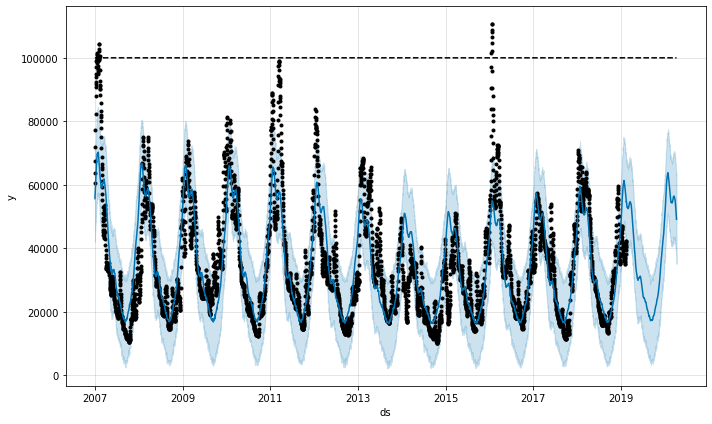

In [13]:
fig1 = model.plot(forecast)

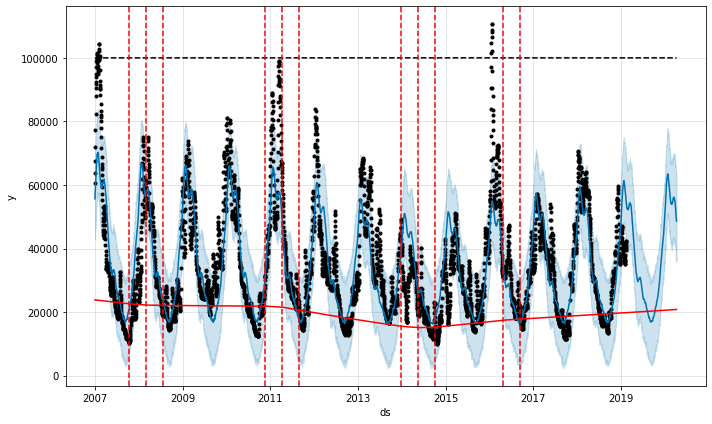

In [49]:
from fbprophet.plot import add_changepoints_to_plot
fig3 = model.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), model, forecast)

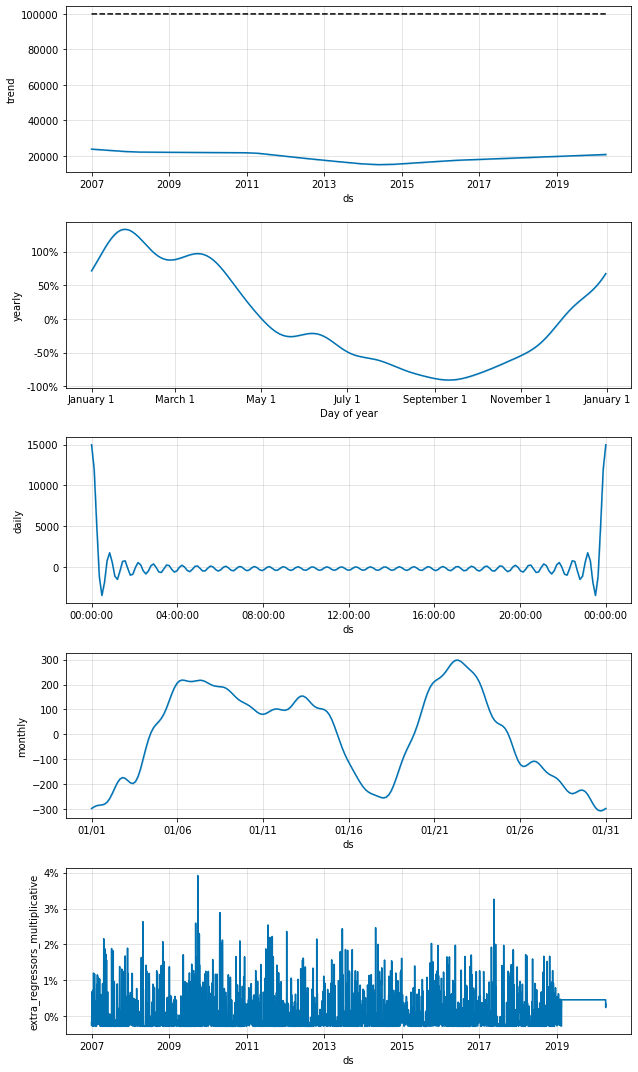

In [50]:
fig2 = model.plot_components(forecast)

In [51]:
forecast

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,ENA_chuva,ENA_chuva_lower,ENA_chuva_upper,...,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2007-01-01,23852.217325,100000,42947.338621,68614.844343,23852.217325,23852.217325,-0.001885,-0.001885,-0.001885,...,202.407878,202.407878,202.407878,0.696427,0.696427,0.696427,0.698311,0.698311,0.698311,55651.723590
1,2007-01-02,23847.807830,100000,42952.162201,70164.765581,23847.807830,23847.807830,-0.002591,-0.002591,-0.002591,...,184.086639,184.086639,184.086639,0.729427,0.729427,0.729427,0.732017,0.732017,0.732017,56412.900088
2,2007-01-03,23843.398894,100000,44237.639649,69107.083620,23843.398894,23843.398894,0.001675,0.001675,0.001675,...,128.058930,128.058930,128.058930,0.768393,0.768393,0.768393,0.766718,0.766718,0.766718,57278.342799
3,2007-01-04,23838.990519,100000,44667.601842,70542.546210,23838.990519,23838.990519,0.004171,0.004171,0.004171,...,82.494581,82.494581,82.494581,0.806419,0.806419,0.806419,0.802248,0.802248,0.802248,58131.470383
4,2007-01-05,23834.582703,100000,46245.441328,72207.174566,23834.582703,23834.582703,0.006805,0.006805,0.006805,...,102.200292,102.200292,102.200292,0.845222,0.845222,0.845222,0.838417,0.838417,0.838417,59068.066182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,2020-04-04,20817.977271,100000,37888.483990,63462.465037,20290.921966,21391.271664,0.004583,0.004583,0.004583,...,-301.611633,-301.611633,-301.611633,0.724121,0.724121,0.724121,0.719538,0.719538,0.719538,50576.878026
4843,2020-04-05,20820.446639,100000,37018.154179,63324.766100,20292.620751,21395.612494,0.004583,0.004583,0.004583,...,-283.248520,-283.248520,-283.248520,0.698211,0.698211,0.698211,0.693628,0.693628,0.693628,50060.040345
4844,2020-04-06,20822.916223,100000,37362.490571,63429.437547,20294.319658,21399.946771,0.004583,0.004583,0.004583,...,-197.476927,-197.476927,-197.476927,0.671664,0.671664,0.671664,0.667081,0.667081,0.667081,49597.225592
4845,2020-04-07,20825.386023,100000,35898.228804,63243.772640,20295.633298,21403.755865,0.002429,0.002429,0.002429,...,-195.892498,-195.892498,-195.892498,0.642438,0.642438,0.642438,0.640009,0.640009,0.640009,48994.280921


In [44]:
forecast['yhat'][-16:]

4839    52154.524683
4840    51617.963971
4841    51101.270784
4842    50503.548701
4843    49986.702321
4844    49523.878870
4845    49078.146143
4846    48736.154681
4847    48274.659501
4848    47794.437477
4849    47292.315266
4850    46621.657861
4851    45965.524220
4852    45220.365077
4853    44640.349642
4854    44090.565350
Name: yhat, dtype: float64

In [20]:
from fbprophet.diagnostics import performance_metrics,cross_validation
df_cv = cross_validation(model, horizon='16 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 506 forecasts with cutoffs between 2008-01-07 00:00:00 and 2019-01-29 00:00:00


KeyboardInterrupt: 

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')